In [1]:
import os

import numpy as np
import pandas as pd
import nibabel as nib

In [2]:
os.chdir('..')

# EDA

## Let's test loading one of the images into a numpy array

Next are the functions created by Xinrui with the modification to skip the files that start with `._`. However these load all images into a list and I think it causes memory overflow

In [3]:
def read_training_data(data_path):
    '''Read training data'''
    imgs = []
    lbls = []
    for f in os.listdir(os.path.join(data_path, 'imagesTr')):
        if '.DS_Store' in f or '._' in f:
            continue
        imgs.append( nib.load(os.path.join(data_path, 'imagesTr', f)).get_fdata() )
        lbls.append( nib.load(os.path.join(data_path, 'labelsTr', f)).get_fdata() )
    return imgs, lbls

def read_testing_data(data_path):
    '''Read testing data'''
    imgs = []
    for f in os.listdir(os.path.join(data_path, 'imagesTs')):
        if '.DS_Store' in f or '._' in f:
            continue
        imgs.append( nib.load(os.path.join(data_path, 'imagesTs', f)).get_fdata() )
    return imgs

To avoid that, let's use a generator that gives returns the arrays of the images one by one

In [4]:
def read_nib_images(data_dir, read_train_data, 
                    train_img_dir='imagesTr',
                    train_img_label_dir='labelsTr',
                    test_img_dir='imagesTs'):
  
    '''Read ct scan data'''
    if read_train_data: 
      train_img_dir_path = os.path.join(data_dir, train_img_dir)
      train_img_label_dir_path = os.path.join(data_dir, train_img_label_dir)

      # Read training images along with their labels
      for f in os.listdir(train_img_dir_path):
          if '.DS_Store' in f or '._' in f:
              continue 
          
          ct_img_array = nib.load(os.path.join(train_img_dir_path, f)).get_fdata() 
          ct_img_label_array = nib.load(os.path.join(train_img_label_dir_path, f)).get_fdata()
       
          yield ct_img_array, ct_img_label_array
          
    else:
      test_img_dir_path = os.path.join(data_dir, test_img_dir)
      for f in os.listdir(test_img_dir_path):
          
          if '.DS_Store' in f or '._' in f:
              continue 
          
          ct_img_array = nib.load(os.path.join(test_img_dir_path, f)).get_fdata() 
          yield ct_img_array

    


In [5]:
train_data_generator = read_nib_images(data_dir='ml4h_proj1_colon_cancer_ct', read_train_data=True, train_img_dir='imagesTr', train_img_label_dir='labelsTr')
test_data_generator = read_nib_images(data_dir='ml4h_proj1_colon_cancer_ct', read_train_data=False, test_img_dir='imagesTs')

To go image by image use `next()`

In [6]:
train_img_1, label_img_1 = next(train_data_generator)

In [7]:
print(train_img_1.shape)
print(label_img_1.shape)

(512, 512, 60)
(512, 512, 60)


In [8]:
type(train_img_1)

numpy.ndarray

Or in a for loop

In [9]:
train_data_generator = read_nib_images(data_dir='ml4h_proj1_colon_cancer_ct', read_train_data=True, train_img_dir='imagesTr', train_img_label_dir='labelsTr')

train_img_shapes = list()
label_img_shapes = list()

for i, (train_img_i, label_img_i) in enumerate(train_data_generator): 
  train_img_shapes.append(train_img_i.shape)
  label_img_shapes.append(label_img_i.shape)

  # verify if there is a label for each channel in the image
  assert train_img_i.shape == label_img_i.shape
    
  if i == 10:
    break


Let's get a histogram of the different depths of the trainset images

<AxesSubplot:ylabel='Frequency'>

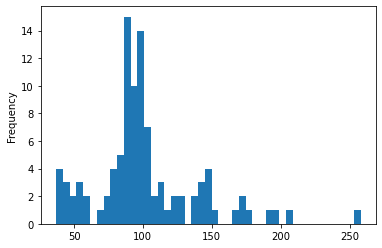

In [10]:
pd.DataFrame(train_img_shapes)[2].plot.hist(bins=45)

## Let's visualize some images and their labeled cancer/not cancer pixels

In [11]:
import matplotlib.pyplot as plt

In [12]:
train_data_generator = read_nib_images(data_dir='ml4h_proj1_colon_cancer_ct', read_train_data=True, train_img_dir='imagesTr', train_img_label_dir='labelsTr')
train_img_1, label_img_1 = next(train_data_generator)

cut: 0


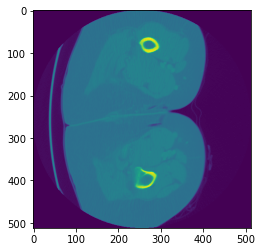

cut: 5


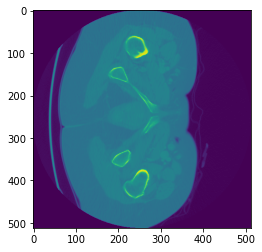

cut: 10


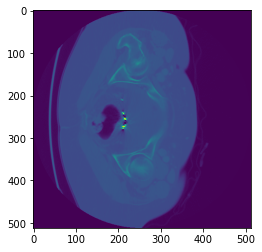

cut: 15


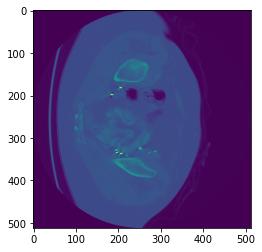

cut: 20


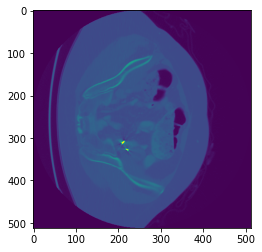

cut: 25


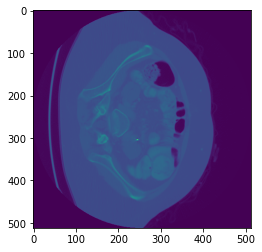

cut: 30


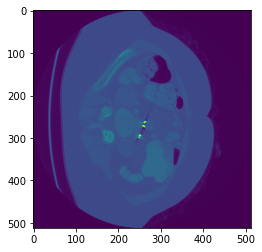

cut: 35


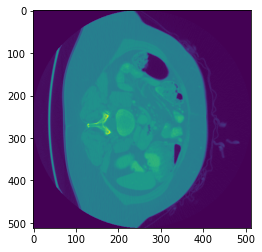

cut: 40


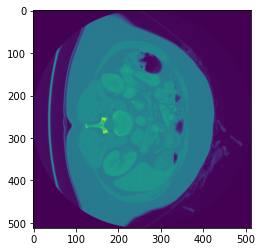

cut: 45


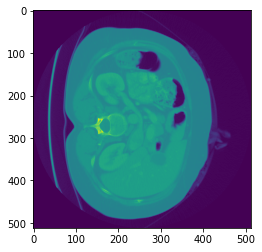

cut: 50


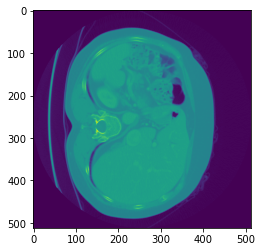

cut: 55


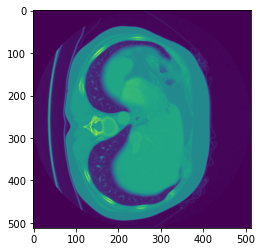

cut: 59


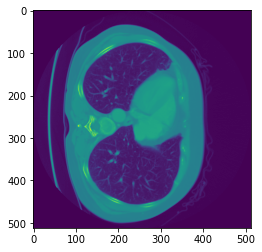

In [13]:
for cut in range(0, train_img_1.shape[2], 5):
  print(f'cut: {cut}')
  plt.imshow(train_img_1[:,:,cut])
  plt.show()
  plt.close()

print(f'cut: {train_img_1.shape[2]-1}')
plt.imshow(train_img_1[:,:,train_img_1.shape[2]-1])
plt.show()
plt.close()


Let's check now many of the cuts where labeled with cancer

cut 51 has labeled cancer pixels


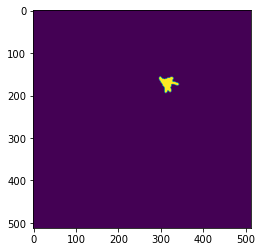

cut 52 has labeled cancer pixels


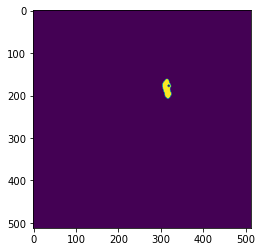

cut 53 has labeled cancer pixels


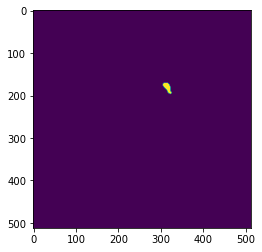

In [14]:
for cut in range(0, label_img_1.shape[2]):
    if (label_img_1[:,:,cut] == 0).all():
        continue
    else:
        print(f'cut {cut} has labeled cancer pixels')
        plt.imshow(label_img_1[:,:,cut])
        plt.show()
        plt.close()


Let's see it overlayed with the original cuts of the CT scan when there is cancer


cut 51 has labeled cancer pixels


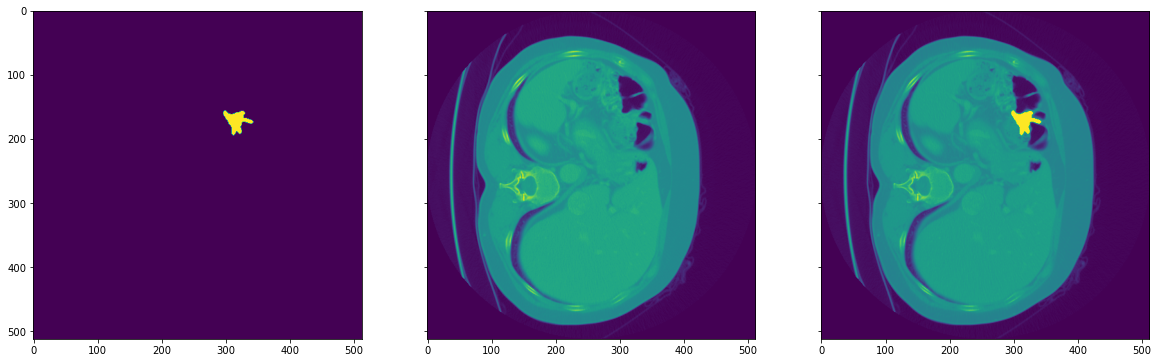

cut 52 has labeled cancer pixels


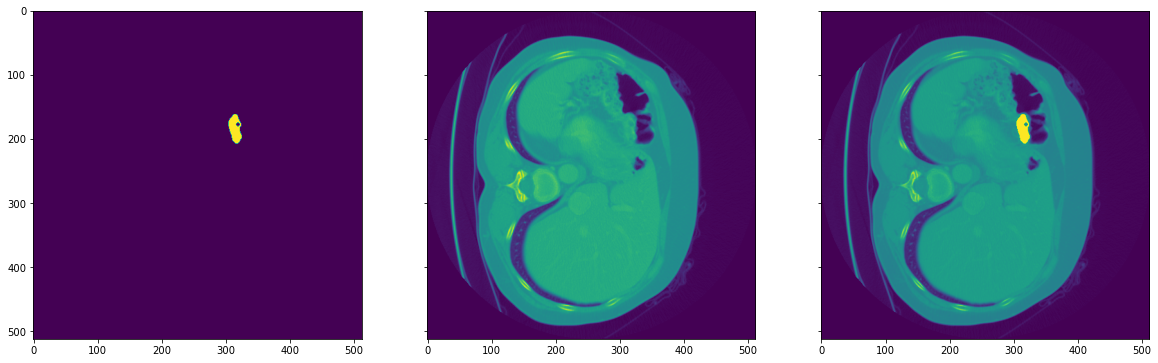

cut 53 has labeled cancer pixels


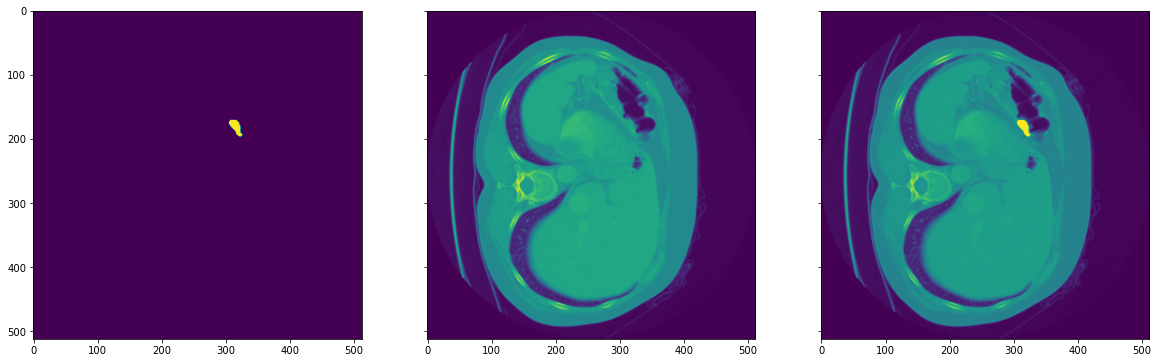

In [15]:
for cut in range(0, label_img_1.shape[2]):
  if (label_img_1[:,:,cut] == 0).all():
    continue
  else:
    print(f'cut {cut} has labeled cancer pixels')

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    f.set_size_inches(20,20)

    ax1.imshow(label_img_1[:,:,cut])
    ax2.imshow(train_img_1[:,:,cut])
    ax3.imshow(np.where(label_img_1[:,:,cut], 1024, train_img_1[:,:,cut]))
    plt.show()
    plt.close()


It is very very hard to see with a naked not expert eye. 

#### Let's check if when cancerous pixels are detected, in which cut they were detected, the total number of cuts of the scan, the pixel area they occupy.

Let's go over all the images and store the information then in the following way:

`[image_name, total_cuts_img_i, cuts_img_i_with_cancer_pixels, area_cancer_pixels_cut_i]`

In [16]:
def read_nib_images(data_dir, read_train_data, 
                    train_img_dir='imagesTr',
                    train_img_label_dir='labelsTr',
                    test_img_dir='imagesTs'):
  
    '''Read ct scan data'''
    if read_train_data: 
      train_img_dir_path = os.path.join(data_dir, train_img_dir)
      train_img_label_dir_path = os.path.join(data_dir, train_img_label_dir)

      # Read training images along with their labels
      for f in os.listdir(train_img_dir_path):
          if '.DS_Store' in f or '._' in f:
              continue 
          
          ct_img_array = nib.load(os.path.join(train_img_dir_path, f)).get_fdata() 
          ct_img_label_array = nib.load(os.path.join(train_img_label_dir_path, f)).get_fdata()

          yield f, ct_img_array, ct_img_label_array
          
    else:
      test_img_dir_path = os.path.join(data_dir, test_img_dir)
      for f in os.listdir(test_img_dir_path):
          
          if '.DS_Store' in f or '._' in f:
              continue 
          
          ct_img_array = nib.load(os.path.join(test_img_dir_path, f)).get_fdata() 
          yield f, ct_img_array

In [17]:
train_data_generator = read_nib_images(data_dir='ml4h_proj1_colon_cancer_ct', read_train_data=True, train_img_dir='imagesTr', train_img_label_dir='labelsTr')

cancer_pixel_info = list()

for f, _, label_img_i in train_data_generator: 
  for cut in range(0, label_img_i.shape[2]):
    if (label_img_i[:,:,cut] == 0).all():
      continue
    
    else:
      cut_cancer_pixel_area_i = label_img_i[:,:,cut].sum()
      cancer_pixel_info.append(
          [f, label_img_i.shape[2], cut, cut_cancer_pixel_area_i]
           )

In [18]:
cancer_pixels_df = pd.DataFrame(cancer_pixel_info, 
             columns=['image_name', 'depth', 'depth_i', 'cancer_pixel_area'])\
  .set_index('image_name').sort_index()

In [19]:
cancer_pixels_df.head()

,depth,depth_i,cancer_pixel_area
image_name,,,
colon_001.nii.gz,60,51,841.0
colon_001.nii.gz,60,52,646.0
colon_001.nii.gz,60,53,296.0
colon_005.nii.gz,98,44,278.0
colon_005.nii.gz,98,50,270.0


In [20]:
# cancer_pixels_df.to_pickle('cancer_pixels_df')

#### Let's check if cancer shows at a specific depth

<AxesSubplot:ylabel='Frequency'>

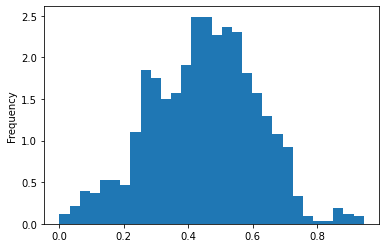

In [21]:
(cancer_pixels_df.depth_i/cancer_pixels_df.depth).plot.hist(bins=30, density=True)

This is useful, the presence of cancer distributes somewhat normally around the middle depth of the scan. Probably means they have a good idea of where it will show up and kind of center the scan before hand.

#### Let's check the distribution of numbers of cuts with cancer in all images

<AxesSubplot:ylabel='Frequency'>

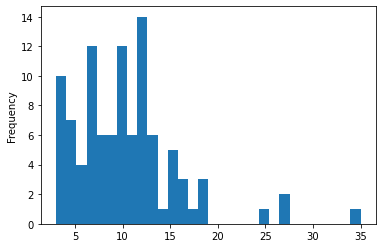

In [22]:
total_cuts_srs =cancer_pixels_df.groupby('image_name')['depth_i'].count()
total_cuts_srs.plot.hist(bins=30)

In [23]:
total_cuts_srs.quantile([0.25,0.5,0.75,0.8, 0.95, 0.99])

0.25     7.00
0.50    10.00
0.75    12.00
0.80    13.00
0.95    18.00
0.99    27.08
Name: depth_i, dtype: float64

The longest one has 35 cuts with cancer detected. This probably means as a rough estimate that we could use bewteen 10 and 35 kernels when reading the image as a whole. 

#### Let's check the distribution of consecutive cuts with cancer

<AxesSubplot:ylabel='Frequency'>

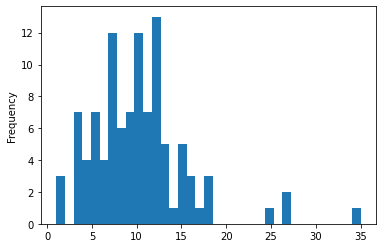

In [24]:
cancer_pixels_df['depth_i_diff_1'] = \
  cancer_pixels_df.groupby('image_name')[['depth_i']].diff(1).fillna(1000) #-\
  #cancer_pixels_df.groupby('image_name')[['depth_i']].diff(-1).fillna(0)

#cancer_pixels_df['depth_i_diff_1'] = \
cancer_pixels_df['consecutive_start'] = cancer_pixels_df['depth_i_diff_1'] > 1

cancer_pixels_df[['depth_i', 'depth_i_diff_1', 'consecutive_start']].head(20)

cancer_pixels_df['consecutive_group'] = cancer_pixels_df[['depth_i', 'depth_i_diff_1', 'consecutive_start']]\
  .groupby(level=0)[['consecutive_start']].cumsum()

cancer_pixels_df[['depth_i', 'depth_i_diff_1', 'consecutive_start', 'consecutive_group']].head(20)

consecutive_pixel_count = cancer_pixels_df.set_index('consecutive_group', append=True)\
  .groupby(level=[0,1])['consecutive_start'].count()
  
consecutive_pixel_count.plot.hist(bins=35)

In [25]:
consecutive_pixel_count.quantile([0.25,0.5,0.75,0.8, 0.95, 0.99])

0.25     7.0
0.50    10.0
0.75    12.0
0.80    13.0
0.95    18.0
0.99    27.0
Name: consecutive_start, dtype: float64

In [26]:
max(consecutive_pixel_count)

35

It seems like it is pretty much the same as if we counted all cuts that where not consecutives. This means we probably do not get too many multiple regions with cancer

In [27]:
consecutive_pixel_count.reset_index(level=1).consecutive_group.value_counts()

1    100
2      4
Name: consecutive_group, dtype: int64

That's it, only 4 out of 100 of the CT scans had more than 1 consecutive regions with cancer. This is probably something to do a sanity check on what the model predits 

#### Let's check the distribution of volumes of the cancer pixels

<AxesSubplot:ylabel='Frequency'>

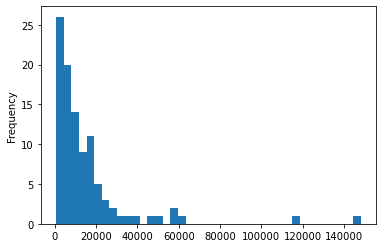

In [28]:
cancer_pixels_df.groupby('image_name')['cancer_pixel_area'].sum().plot.hist(bins=40)

<AxesSubplot:ylabel='Frequency'>

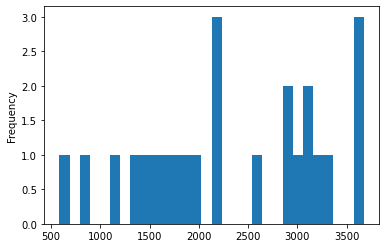

In [29]:
volume_srs =cancer_pixels_df.groupby('image_name')['cancer_pixel_area'].sum()
volume_srs[volume_srs < 4000].plot.hist(bins=30)